In [252]:
import rundec
from math import pi, modf, sqrt
from cmath import exp, log
import json
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.special import zeta
from scipy.integrate import quad, odeint
crd = rundec.CRunDec()

In [26]:
# complex integration
def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return scipy.real(func(x))
    def imag_func(x):
        return scipy.imag(func(x))
    real_integral = quad(real_func, a, b, **kwargs)
    imag_integral = quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

# Plot spectral function for fitted parameters

In [238]:
with open('./alephData/alephVpA.json') as f:
    aleph_vpa = json.load(f)['data']
data = aleph_vpa
name = 'V+A'
alpha = 0.3232 #see fitting table in thesis for wKin (best Chi2)

In [28]:
sTau = 1.77682**2
BVpA = 51.116
Be = 17.815
Vud = 0.97425
SEW = 1.0201

def kinematicWeight(x):
    return (1-x)**2*(1+2*x)

def experimental_spectral_function(s, sfm2, ds):
    return sTau/12/pi**2/SEW/Vud**2/Be/kinematicWeight(s/sTau)/ds*sfm2

rho = list(map(lambda i: experimental_spectral_function(data['sbin'][i], data['sfm2'][i], data['dsbin'][i]), range(len(data['sbin']))))
rhoErr = list(map(lambda i: experimental_spectral_function(data['sbin'][i], data['derr'][i], data['dsbin'][i]), range(len(data['sbin']))))

## Beta-function and Adler-function coefficients

In [202]:
nf = 3
nc = 3

b = np.zeros(5)
b[1] = 1/6*(11*nc - 2*nf)
b[2] = 51/4 - 19/12*nf
b[3] = 2857/64 - 5033/576*nf + 325/1728*nf**2
b[4] = 149753/768 + 891/32*zeta(3) -(1078361/20736 + 1627/864*zeta(3))*nf + (50065/20736 + 809/1296*zeta(3))*nf**2 + 1093/93312*nf**3

c = np.zeros((6,6))
c[0][0] = -5/3; c[0][1] = 1
c[1][1] = 1; c[1][2] = 0
c[2][1] = 365/24 - 11*zeta(3) - (11/12 - 2/3*zeta(3))*nf
c[2][2] = -b[1]*c[1][1]/4; c[2][3] = 0
c[3][1] = 87029/288 - 1103/4*zeta(3) + 275/6*zeta(5) +(-7847/216 + 262/9*zeta(3) -25/9*zeta(5))*nf + (151/162 -19/27 * zeta(3))*nf**2
c[3][2] = -1/4*(b[2]*c[1][1] + 2*b[1]*c[2][1])
c[3][3] = b[1]**2/12*c[1][1]; c[3][4] = 0;
c[4][1] = 78631453/20736 - 1704247/432*zeta(3) + 4185/8*zeta(3)**2 + 34165/96*zeta(5) - 1995/16*zeta(7)
c[4][2] = -1/4*(b[3]*c[1][1]+2*b[2]*c[2][1]+3*b[1]*c[3][1]);
c[4][3] = b[1]/24*(5*b[2]*c[1][1]+6*b[1]*c[2][1])
c[4][4] = -b[1]**3/32*c[1][1]; c[4][5] = 0
c[5][1] = 283
c[5][2] = 1/4*(-b[4]*c[1][1] - 2*b[3]*c[2][1]-3*b[2]*c[3][1]-4*b[1]*c[4][1]);
c[5][3] = 1/24*(12*c[3][1]*b[1]**2+6*b[1]*b[3]*c[1][1]+14*b[2]*b[1]*c[2][1]+3*b[2]**2*c[1][1]);
c[5][4] = 1/96*(-12*b[1]**3*c[2][1]-13*b[2]*b[1]**2*c[1][1])
c[5][5] = 1/80*b[1]**4*c[1][1]
print(c[0][0])

-1.6666666666666667


## Theoretical spectral function

In [261]:
mTau = 1776.82
def theoretical_spectral_function(s, alpha):
    order = 1
    sum = 0
    for n in range(order+1):
        for k in range(n+1):
            sum = sum + nc/24/pi**3*alpha**n*k*c[n][k]*complex_quadrature(
                lambda x: log(-s*exp(-1j*x)/mTau**2)**(k-1), 0, 2*pi
            )[0]
    return sum

# following Jamin2008, Spectral function eq. 6 and e. 8
def theoretical_spectral_function_FOPT(s, alpha):
    order = 3
    sum = 0
    for n in range(order+1):
        for l in range(int(modf(n-1/2)[1])+1):
            sum = sum + (crd.AlphasExact(alpha, sTau, s, 3, 3)/pi)**n*c[n][2*l+1]*(-pi**2)**l

    return nc/12/pi**2*(1 + sum)

In [263]:
sLin = np.linspace(1, 3.08, 100)
th_func = list(map(lambda x: theoretical_spectral_function_FOPT(x, alpha), sLin))

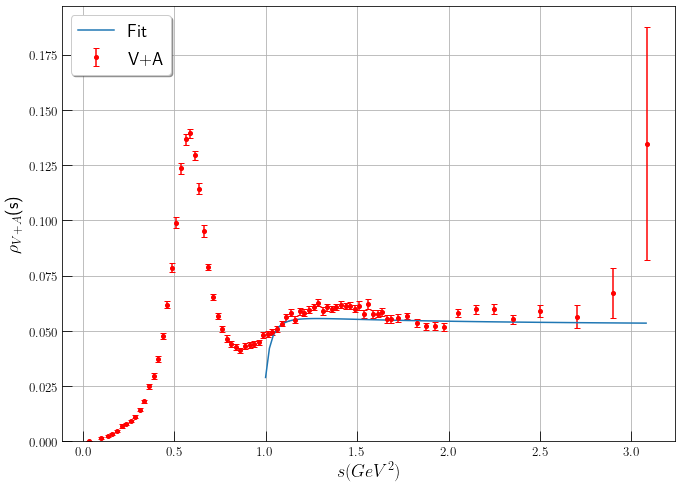

In [264]:
line = plt.errorbar(aleph_vpa['sbin'][:-1], rho[:-1], color='r', yerr=rhoErr[:-1], capsize=3, fmt='o', markersize=4, label=name)
plt.plot(sLin, scipy.real(th_func), label='Fit')
# axes = plt.gca()
#axes
fig = plt.gcf()
fig.set_size_inches(11,8)
fig.patch.set_facecolor('white')
plt.ylim(bottom=0)


plt.legend()
plt.ylabel(r'$\rho_{'+name+'}$(s)')
plt.xlabel('$s(GeV^2)$')
#plt.savefig(name+'.png', transparent=True)
plt.savefig('fitWKinAlD6D8SpecFunc.png',format='png')

In [103]:
def beta_function(a):
    return b[1]*a**2 + b[2]*a**3 + b[3]*a**4 + b[4]*a**5

0.4850395671988739


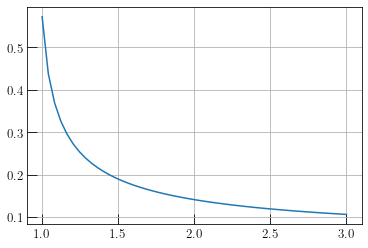

In [260]:
print(crd.AlphasExact(0.319, sTau, 1, 3, 3)/pi)
xLin = np.linspace(1, 3)
y = list(map(lambda x: crd.AlphasExact(0.323, sTau, x, 3, 3)/pi, xLin))
plt.plot(xLin, y)